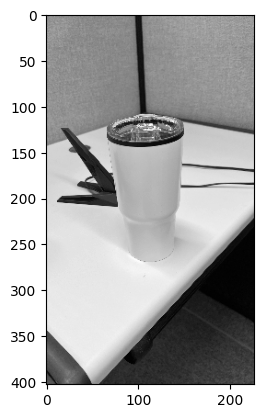

In [37]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

filepath = os.getcwd()

image1 = cv2.imread("./sample1.jpg", cv2.IMREAD_GRAYSCALE)
image1 = cv2.resize(image1, dsize=(0,0), fx=0.1, fy=0.1)
image1 = np.float32(image1)
image1 = (image1 - np.min(image1)) / (np.max(image1) - np.min(image1))
plt.imshow(image1, cmap="gray")
plt.show()

In [39]:
image1.shape

(403, 227)

In [40]:
def convolve2d(image, kernel):
    image_height, image_width = image.shape[0], image.shape[1]
    kernel_height, kernel_width = kernel.shape[0], kernel.shape[1]

    pad_height = kernel_height // 2
    pad_width = kernel_width // 2

    output = np.zeros_like(image)
    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant', constant_values=0)
    
    for x in range(image_height):
        for y in range(image_width):
            region = padded_image[x:x+kernel_height, y:y+kernel_width]
            output[x, y] = np.sum(region * kernel)
    
    return output

def compute_gradients(image):
    kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    kernel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    
    gradient_x = convolve2d(image, kernel_x)
    gradient_y = convolve2d(image, kernel_y)
    magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    orientation = np.arctan2(gradient_y, gradient_x) * 180 / np.pi
    orientation[orientation < 0] += 360
    
    return magnitude, orientation

In [41]:
magnitude, orientation = compute_gradients(image1)

In [43]:
cell_size = 8
hist_bins = 8
histogram = np.zeros((image1.shape[0] // cell_size, image1.shape[1] // cell_size, hist_bins))

for i in range(0, image1.shape[0] // cell_size):
    for j in range(0, image1.shape[1] // cell_size):
        for k in range(cell_size):
            for l in range(cell_size):
                bin = int(orientation[i * cell_size + k, j * cell_size + l] // (360 / hist_bins)) % hist_bins
                histogram[i, j, bin] += magnitude[i * cell_size + k, j * cell_size + l]


In [44]:
block_size = 2
feature_vector = []

for i in range(0, histogram.shape[0] - block_size + 1):
    for j in range(0, histogram.shape[1] - block_size + 1):
        block = histogram[i:i+block_size, j:j+block_size, :]
        norm = np.linalg.norm(block)
        if norm > 0:
            block = block / norm
        feature_vector.extend(block.ravel())


In [57]:
def show_feature_vector(image, cell_size, hist_bins, histogram, magnitude=0):
   # 이미지를 그립니다.
    plt.figure(figsize=(10,10))
    plt.imshow(image, cmap='gray')
    # 각 셀에 대해 히스토그램 bin을 그립니다.
    for i in range(0, image.shape[0] // cell_size):
        for j in range(0, image.shape[1] // cell_size):
            cell_center = (i * cell_size + cell_size // 2, j * cell_size + cell_size // 2)
            for bin in range(hist_bins):
                angle = bin * (180 / hist_bins) + (180 / hist_bins / 2)
                feat_magnitude = histogram[i, j, bin]
                if feat_magnitude < magnitude:
                    continue
                
                dx = feat_magnitude * np.cos(np.deg2rad(angle))
                dy = feat_magnitude * np.sin(np.deg2rad(angle))
                plt.arrow(cell_center[1], cell_center[0], dx, dy, color='red', head_width=0.5, head_length=0.5) 
                
    plt.show()

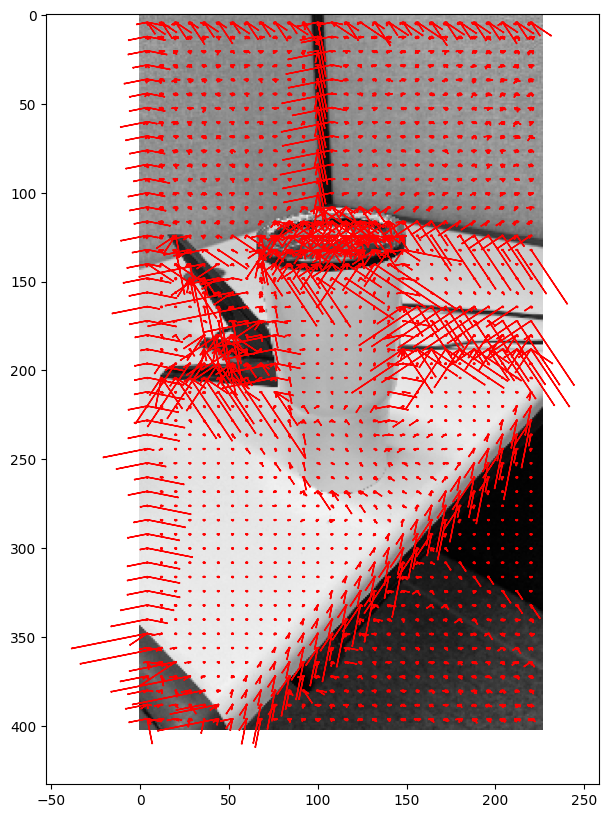

In [58]:
show_feature_vector(image1, cell_size, hist_bins, histogram)

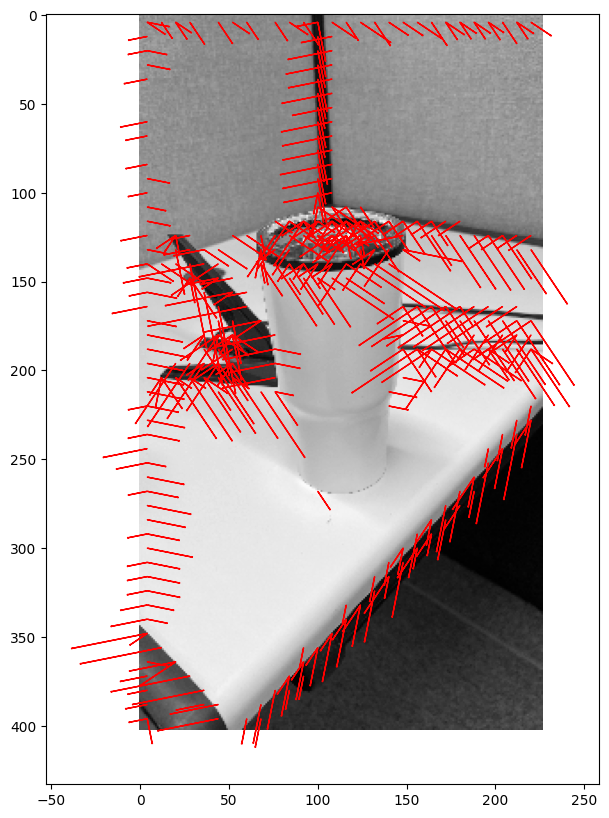

In [59]:
show_feature_vector(image1, cell_size, hist_bins, histogram, magnitude=10)